# Teste A/B

O objetivo desse teste é simular a implementação de um teste A/B, usando uma base de dados do curso da Udacity¹. O propósito do teste conduzido é verificar o impacto de uma landing page em um site. Cabe a esse estudo determinar se a implementação da landing page no site causará um aumento de conversão de usuários significativo.

O teste A/B é um método de experimentação que tem como objetivo comparar duas versões de uma variável para definir se elas performam diferentement eem um ambiente controlado. Nesse caso, os usuários foram divididos em dois grupos amostrais aleatoriamente: o grupo de controle e o grupo de tratamento. Os usuários do grupo de controle foram expostos à página do site sem landing page. Já os usuários do grupo de tratamento foram expostos à landing page. A partir de uma análise dos resultados do teste, espera-se determinar se a implementação da landing page aumentará a conversão de usuários de forma significativa.

A fim de analisar os dados do teste conduzido, o projeto divide-se em tópicos:

1. Tratamento da base de dados
2. Análise exploratória dos dados
3. Teste de hipótese
4. Conclusões
5. Referências

# 1. Tratamento da base de dados

Antes de analisar os resultados, é necessário verificar a base de dados. Primeiramente, é preciso garantir que todos os usuários do grupo de controle visualizaram a página do site usual e todos os usuários do grupo de tratamento visualizaram a landing page. Analisando a base de dados, percebe-se usuários repetidos e que visualizaram a página errada. Para corrigir esse erro, foram excluídas as observações referentes a usuários visualizando a página errada durante o exerimento.

Além disso, foi necessário garantir que cada usuário aparece em apenas uma obervação da base de dados e para isso foram excluídas duplicatas na coluna user_id. Como não constam valores nulos, não foi necessário realizar alterações nesse sentido. Como o primeiro e último dia do experimento referem-se apenas a meio período, foram retirados da base de dados.

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.stats.api as sms
import math

In [44]:
df = pd.read_csv('ab_data.csv', sep=',')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [45]:
df.shape

(294478, 5)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [47]:
df.drop(df.loc[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index, inplace=True)
df.drop(df.loc[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index, inplace=True)

In [48]:
len(df['user_id'].unique())

290584

In [49]:
df.drop_duplicates(['user_id'], inplace=True)

In [50]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df = df.loc[(df['date'] > '2017-01-02') & (df['date'] < '2017-01-24')]

# 2. Análise exploratória dos dados

A partir da análise exploratória dos dados, é possível perceber que no total 290.584 usuários participaram do experimento, divididos em grupo de controle (145.274) e grupo de tratamento (145.310).

O experimento foi realizado entre os dias 03/01/2017 e 23/01/2017. A média de conversão do site no período de é de 12% e os valores de conversão vão de 274 a 850.

Durante o experimento, o grupo de tratamento apresentou números levemente maiores de conversão: enquanto a taxa de conversão do grupo de controle foi de 11,88%, a taxa do grupo de tratamento foi de 12,03%.

In [51]:
df['converted'].mean()

0.11952623478483404

In [52]:
df.groupby(['group', 'converted']).describe()

user_id                                         \
                        count           mean           std       min   
group     converted                                                    
control   0          121974.0  788169.169430  91250.426029  630002.0   
          1           16687.0  787533.141427  91403.303669  630009.0   
treatment 0          122302.0  787555.219252  91083.376318  630000.0   
          1           16474.0  789609.137064  91474.165026  630001.0   

                                                               
                           25%       50%        75%       max  
group     converted                                            
control   0          709335.25  788191.5  867093.50  945998.0  
          1          708545.00  786615.0  867634.00  945991.0  
treatment 0          708467.25  787647.0  866260.50  945999.0  
          1          710848.25  789451.5  868757.75  945989.0

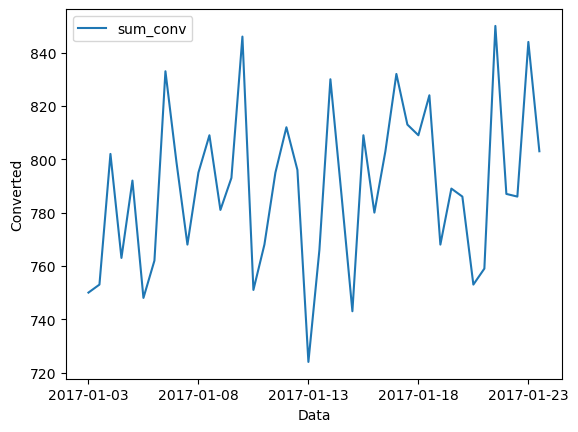

In [53]:
df_grouped = df.groupby(['group', 'date']).agg(sum_conv=('converted', 'sum')).sort_values('date', ascending=True).reset_index()
graph = df_grouped.plot(x='date', xlabel='Data', ylabel='Converted')
plt.show()

# 3. Teste de hipótese

Ainda que a taxa de conversão do grupo de tratamento tenha apresentado resultados levemente melhores (12,03% contra 11,88%), é preciso determinar se essa diferença é estatisticamente significativa. Para isso, aplica-se aqui um teste de hipótese t, já que a amostra é maior que 30.

A fim de implementar o teste de hipótese, cria-se as seguintes hipóteses:

H0: Usuários que receberam a landing page não terão taxa de conversão maior que os usuários que receberam a página do site usual.

H1: A taxa de conversão de usuários que visualizaram a landing page é maior que a taxa de conversão de usuários que visualizaram a página do site usual.

Com um nível de confiança de 95%, a hipótese nula pode ser rejeitada caso o p-valor seja menor que 0.05. O p-valor do teste-t é de 0.18, o que não nos permite rejeitar a hipótese nula.

In [54]:
control = df[df.group == 'control']['converted']
treatment = df[df.group == 'treatment']['converted']
t_stat, p_val= ss.ttest_ind(control, treatment)
print('T-stat: ', t_stat)
print('p-valor: ', p_val)

T-stat:  1.3269866084738058
p-valor:  0.1845142046548027


In [55]:
confidence_lvl = 0.95

(lower_con, upper_con) = ss.norm.interval(alpha=confidence_lvl, loc=np.mean(control), scale=ss.sem(control))
(lower_treat, upper_treat) = ss.norm.interval(alpha=confidence_lvl, loc=np.mean(treatment), scale=ss.sem(treatment))
print(f"Intervalo de confiança (95%) - grupo de controle: ({lower_con:.5f}, {upper_con:.5f})")
print(f"Intervalo de confiança (95%) - grupo de experimento: ({lower_treat:.5f}, {upper_treat:.5f})")

Intervalo de confiança (95%) - grupo de controle: (0.11863, 0.12206)
Intervalo de confiança (95%) - grupo de experimento: (0.11701, 0.12041)


# 4. Conclusões

Esse estudo teve como objetivo determinar se a implementação da landing page seria economicamente atrativa, ao aumentar as taxas de conversão. Para isso, foi realizado um experimento entre os dias 03/01/2017 e 23/01/2017 em que os usuários foram divididos em grupos de controle e de tratamento. Os usuários do grupo de controle receberam a página do site usual, enquanto os usuários do grupo de tratamento receberam a página do site com landing page.

Durante o experimento, a média da taxa de conversão dos usuários foi de 12% e os usuários do grupo de tratamento apresentaram uma taxa de conversão um pouco mais elevada (12,03%) que a taxa de conversão do grupo de controle (11,88%). Para verificar se esse resultado é estatisticamente significativo, aplicou-se um teste-t para testar as seguintes hipóteses:

H0: Usuários que receberam a landing page não terão taxa de conversão maior que os usuários que receberam a página do site usual.
H1: A taxa de conversão de usuários que visualizaram a landing page é maior que a taxa de conversão de usuários que visualizaram a página do site usual.

Com um nível de confiança de 95%, o p-valor foi de 0.18, ou seja, não é possível rejeitar a hipótese nula. Isso significa que os resultados do grupo de tratamento não são estatisticamente significativos e a landing page implementada não é economicamente atrativa. Como evolução do projeto, é possível desenhar um outro experimento para aumentar as taxas de conversão dos usuários.

# 5. Referências

1. https://github.com/erdiolmezogullari/ml-ab-testing

2. https://github.com/gabrielleuzinger/A-B-Test/blob/main/A-B%20Test.ipynb

3. https://www.analyticsvidhya.com/blog/2020/10/ab-testing-data-science/

4. https://www.analyticsvidhya.com/blog/2020/10/ab-testing-data-science/